# Proyecto 2 Reconocimiento de Patrones

José Julián Camacho Hernández

Leonardo Guillén Fernández

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import time
import math
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import display
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import label_binarize, LabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, roc_auc_score, roc_curve, f1_score

# MLP

In [4]:
def computeMetrics(y_test, y_pred, training_time):
    n_classes = 4
    acc = accuracy_score(y_test, y_pred)                        # Calcular la exactitud
    f1 = f1_score(y_test, y_pred, average='macro')              # Calcular F1 score
    rec = recall_score(y_test, y_pred, average='macro')         # Calcular el recall
    prec = precision_score(y_test, y_pred, average='macro')     # Calcular la precisión
    
    # Calcular macro AUC
    test_labels_binary = label_binarize(y_test, classes=np.unique(y_test))
    y_pred_one_hot = label_binarize(y_pred, classes=np.unique(y_test))
    n_classes = test_labels_binary.shape[1]
    auc_scores = []
    for i in range(n_classes):
        y_test_i = test_labels_binary[:, i]     
        y_pred_i = y_pred_one_hot[:, i]                 
        auc_i = roc_auc_score(y_test_i, y_pred_i)
        auc_scores.append(auc_i)
    macro_auc = np.mean(auc_scores)

    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    y_pred_bin = np.zeros((len(y_test), n_classes))
    y_pred_bin[np.arange(len(y_test)), y_pred] = 1    
    metrics = {"Accuracy":acc, "Precision":prec, "Recall":rec, "F1 Score":f1, "AUC":macro_auc, "Tiempo de entrenamiento":training_time}
    df = pd.DataFrame(metrics, index = [0])
    display(df)

    # Calcular la curva ROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()


## MLP sin feature extractor

In [ ]:
#=====  Cargar y aplicar feature extractor a las imágenes  =====#
X = []
y = []

input_folders = ["drive/MyDrive/COVID-19_Radiography_Dataset/COVID/", 
                 "drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity/",
                 "drive/MyDrive/COVID-19_Radiography_Dataset/Normal/", 
                 "drive/MyDrive/COVID-19_Radiography_Dataset/Viral_Pneumonia/"]

i = 0
for folder in input_folders:
    input_folder = folder
    print(input_folder)
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)                                  # Leer la imagen
            cropped_image = image[20:280, 20:280]                           # Recortar los bordes
            gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)    # Pasarla a escala de grises
            image_np = np.array(gray_image).flatten()                       # COnvertirla en array de 1D
            X.append(image_np)
            y.append(i)
    i+=1

np.save("drive/MyDrive/X.npy", X)
np.save("drive/MyDrive/y.npy", y)

drive/MyDrive/COVID-19_Radiography_Dataset/COVID/
drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity/
drive/MyDrive/COVID-19_Radiography_Dataset/Normal/
drive/MyDrive/COVID-19_Radiography_Dataset/Viral_Pneumonia/


In [5]:
#=====  Feature Engineering  =====#

try:
    X_loaded = np.load("drive/MyDrive/X.npy")
    y_loaded = np.load("drive/MyDrive/y.npy")
except FileNotFoundError:
    print("Error: File not found.")
       
# Dividir los datos en train y test y estratificar
train_X_tensor, test_X_tensor, train_y_tensor, test_y_tensor = train_test_split(
    X_loaded, y_loaded, test_size=0.2, stratify=y_loaded, random_state=42)

# Normalización de los datos de train
scaler = MinMaxScaler()
scaler.fit(train_X_tensor)
scaled_data = scaler.transform(train_X_tensor)
train_X_tensor = scaled_data

# Normalización de los datos de test
scaler = MinMaxScaler()
scaler.fit(test_X_tensor)
scaled_data = scaler.transform(test_X_tensor)
test_X_tensor = scaled_data

# Convertir de numpy array a PyTorch tensor
X_train_tensor = torch.from_numpy(train_X_tensor).float()
X_test_tensor = torch.from_numpy(test_X_tensor).float()
y_train_tensor = torch.from_numpy(train_y_tensor).float()
y_test_tensor = torch.from_numpy(test_y_tensor).float()

# Convertir a tensores de tipo long
y_train_long_tensor = y_train_tensor.long()         
# Convertir a one hot
y_onehot = F.one_hot(y_train_long_tensor, num_classes=4).float()

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, activation):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_layers = nn.ModuleList()
        self.num_classes = num_classes
        self.activation = activation
        # Agregar capas ocultas
        for i, hidden_size in enumerate(hidden_sizes):
            if i == 0:
                self.hidden_layers.append(nn.Linear(input_size, hidden_size))
            else:
                self.hidden_layers.append(nn.Linear(hidden_sizes[i-1], hidden_size))
        # Capa de salida
        self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)
        
    def forward(self, x):
        out = x
        # Pasar por capas ocultas
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.activation(out)
        # Pasar por capa de salida
        out = self.output_layer(out)
        return out

### Diseño # 1
Capas: [67600, 128, 64, 4] | Función de activación: ReLU | epochs = 120

|==========  Entrenando el modelo  ==========|

Epoch: [20/120], Loss: 0.6743
Epoch: [40/120], Loss: 0.5865
Epoch: [60/120], Loss: 0.5410
Epoch: [80/120], Loss: 0.5220
Epoch: [100/120], Loss: 0.4861
Epoch: [120/120], Loss: 0.4604

|==========  Resultados conjunto de prueba  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.731616,0.765814,0.758195,0.754412,0.832505,245.814254


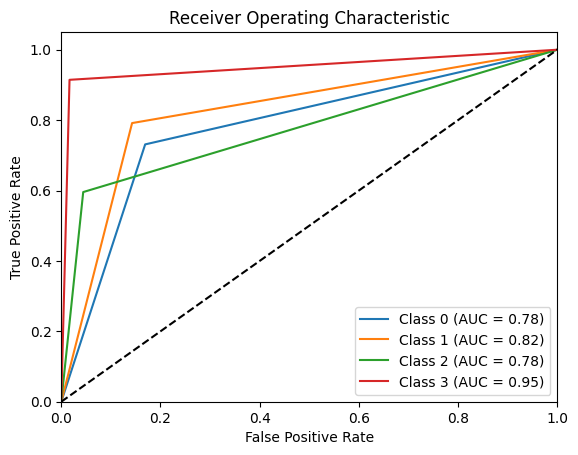

Resultados esperados:  tensor([3., 1., 0., 2., 2., 2., 3., 1.])
Resultados obtenidos:  [1, 1, 0, 2, 2, 2, 3, 1]

|==========  Resultados conjunto de entrenamiento  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.827457,0.85275,0.847135,0.847448,0.893418,245.814254


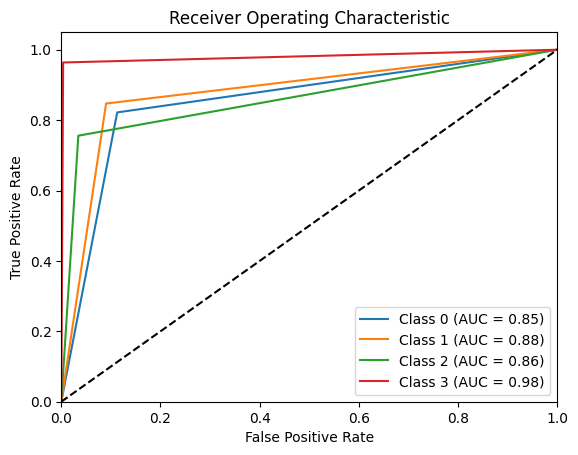

Resultados esperados:  tensor([1., 1., 1., 2., 2., 2., 2., 2.])
Resultados obtenidos:  [1, 1, 0, 2, 2, 2, 2, 2]


In [ ]:
# Convertir datos a PyTorch Dataset
train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
# Definir batch size
batch_size = 32
# Crear DataLoaders
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_ = data.DataLoader(train_dataset, batch_size=batch_size)
# Convertir datos a PyTorch Dataset
val_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)
# Crear DataLoaders
val_loader = data.DataLoader(val_dataset, batch_size=batch_size)

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train_tensor.shape[1]
hidden_sizes = [128, 64]       
num_classes = 4
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation).to(device)  

# Definir funcion de costo
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Entrenamiento del modelo
num_epochs = 120
print('|==========  Entrenando el modelo  ==========|\n')
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        outputs = outputs.float()
        labels = labels.long()
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        average_loss = running_loss / len(train_loader)
        # Imprimir el training loss
    if (epoch+1) % 20 == 0:
        print(f"Epoch: [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

end_time = time.time()
time_taken = end_time - start_time

print('\n|==========  Resultados conjunto de prueba  ==========|\n')
# Evaluar el modelo
model.eval() 
predicted_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.tolist())
    # Obtener métricas
    computeMetrics(y_test_tensor, predicted_labels, time_taken)
    print('Resultados esperados: ', y_test_tensor[:8])
    print('Resultados obtenidos: ', predicted_labels[:8])

print('\n|==========  Resultados conjunto de entrenamiento  ==========|\n')
# Evaluar el modelo con el conjunto de training
model.eval()
predicted_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in train_loader_:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.tolist())
    # Obtener métricas
    computeMetrics(y_train_tensor, predicted_labels, time_taken)
    print('Resultados esperados: ', y_train_tensor[:8])
    print('Resultados obtenidos: ', predicted_labels[:8])


### Diseño # 2
Capas: [67600, 64, 4] | Función de activación: ReLU | epochs = 200

|==========  Entrenando el modelo  ==========|

Epoch: [20/200], Loss: 0.7764
Epoch: [40/200], Loss: 0.7265
Epoch: [60/200], Loss: 0.6844
Epoch: [80/200], Loss: 0.6758
Epoch: [100/200], Loss: 0.6436
Epoch: [120/200], Loss: 0.6516
Epoch: [140/200], Loss: 0.6245
Epoch: [160/200], Loss: 0.6045
Epoch: [180/200], Loss: 0.5989
Epoch: [200/200], Loss: 0.5839

|==========  Resultados conjunto de prueba  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.679157,0.706652,0.704277,0.703723,0.7961,322.855363


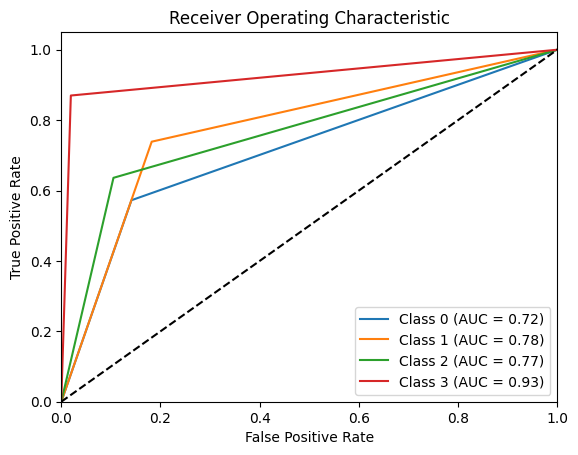

Resultados esperados:  tensor([3., 1., 0., 2., 2., 2., 3., 1.])
Resultados obtenidos:  [1, 0, 0, 2, 2, 2, 3, 1]

|==========  Resultados conjunto de entrenamiento  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.790207,0.819066,0.813647,0.813142,0.869769,322.855363


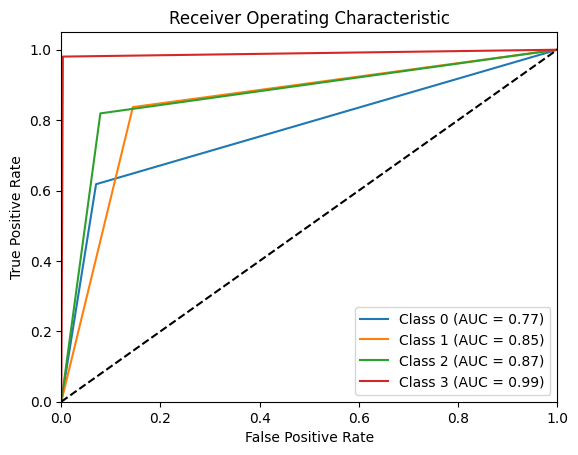

Resultados esperados:  tensor([1., 1., 1., 2., 2., 2., 2., 2.])
Resultados obtenidos:  [1, 1, 1, 2, 1, 2, 2, 2]


In [ ]:
# Convertir datos a PyTorch Dataset
train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
# Definir batch size
batch_size = 32
# Crear DataLoaders
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_ = data.DataLoader(train_dataset, batch_size=batch_size)
# Convertir datos a PyTorch Dataset
val_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)
# Crear DataLoaders
val_loader = data.DataLoader(val_dataset, batch_size=batch_size)

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train_tensor.shape[1]
hidden_sizes = [64]       
num_classes = 4
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation) .to(device)  

# Definir funcion de costo
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Entrenar el modelo
num_epochs = 120
print('|==========  Entrenando el modelo  ==========|\n')
start_time = time.time()
for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        outputs = outputs.float()
        labels = labels.long()
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        average_loss = running_loss / len(train_loader)
        # Imprimir el training loss
    if (epoch+1) % 20 == 0:
        print(f"Epoch: [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

end_time = time.time()
time_taken = end_time - start_time

print('\n|==========  Resultados conjunto de prueba  ==========|\n')
# Evaluar el modelo
model.eval() 
predicted_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.tolist())
    # Obtener métricas
    computeMetrics(y_test_tensor, predicted_labels, time_taken)
    print('Resultados esperados: ', y_test_tensor[:8])
    print('Resultados obtenidos: ', predicted_labels[:8])

print('\n|==========  Resultados conjunto de entrenamiento  ==========|\n')
# Evaluar el modelo con el conjunto de training
model.eval()
predicted_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in train_loader_:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.tolist())
    # Obtener métricas
    computeMetrics(y_train_tensor, predicted_labels, time_taken)
    print('Resultados esperados: ', y_train_tensor[:8])
    print('Resultados obtenidos: ', predicted_labels[:8])


### Diseño # 3
Capas: [67600, 64, 32, 16, 4] | Función de activación: ReLU | epochs = 120

|==========  Entrenando el modelo  ==========|

Epoch: [20/120], Loss: 0.6806
Epoch: [40/120], Loss: 0.5836
Epoch: [60/120], Loss: 0.5530
Epoch: [80/120], Loss: 0.5174
Epoch: [100/120], Loss: 0.4851
Epoch: [120/120], Loss: 0.4569

|==========  Resultados conjunto de prueba  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.728337,0.755751,0.747221,0.75094,0.826114,199.657101


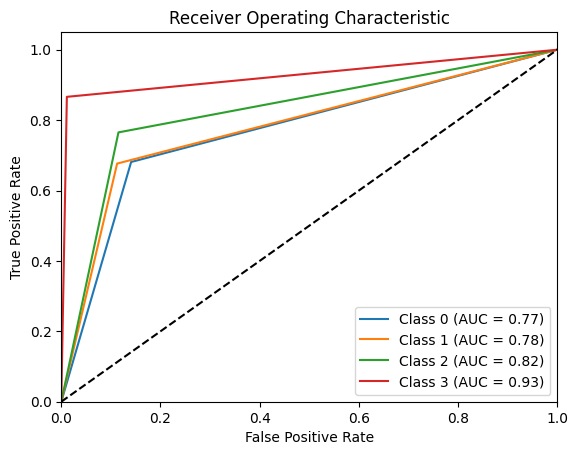

Resultados esperados:  tensor([3., 1., 0., 2., 2., 2., 3., 1.])
Resultados obtenidos:  [0, 1, 0, 2, 2, 2, 3, 1]

|==========  Resultados conjunto de entrenamiento  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.816563,0.842529,0.835268,0.83732,0.885355,199.657101


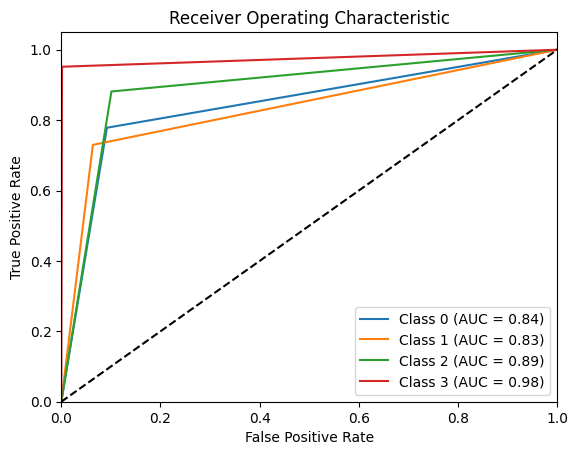

Resultados esperados:  tensor([1., 1., 1., 2., 2., 2., 2., 2.])
Resultados obtenidos:  [1, 0, 1, 2, 2, 2, 2, 2]


In [ ]:
# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train_tensor.shape[1]
hidden_sizes = [64,32,16]       
num_classes = 4
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation) .to(device)  

# Definir funcion de costo
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Entrenar el modelo
num_epochs = 120
print('|==========  Entrenando el modelo  ==========|\n')
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        outputs = outputs.float()
        labels = labels.long()
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        average_loss = running_loss / len(train_loader)
        # Imprimir el training loss
    if (epoch+1) % 20 == 0:
        print(f"Epoch: [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

end_time = time.time()
time_taken = end_time - start_time

print('\n|==========  Resultados conjunto de prueba  ==========|\n')
# Evaluar el modelo
model.eval()
predicted_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.tolist())
    # Obtener métricas
    computeMetrics(y_test_tensor, predicted_labels, time_taken)
    print('Resultados esperados: ', y_test_tensor[:8])
    print('Resultados obtenidos: ', predicted_labels[:8])

print('\n|==========  Resultados conjunto de entrenamiento  ==========|\n')
# Evaluar el modelo con el conjunto de training
model.eval()
predicted_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in train_loader_:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.tolist())
    # Obtener métricas
    computeMetrics(y_train_tensor, predicted_labels, time_taken)
    print('Resultados esperados: ', y_train_tensor[:8])
    print('Resultados obtenidos: ', predicted_labels[:8])

## MLP con feature extractor LBP

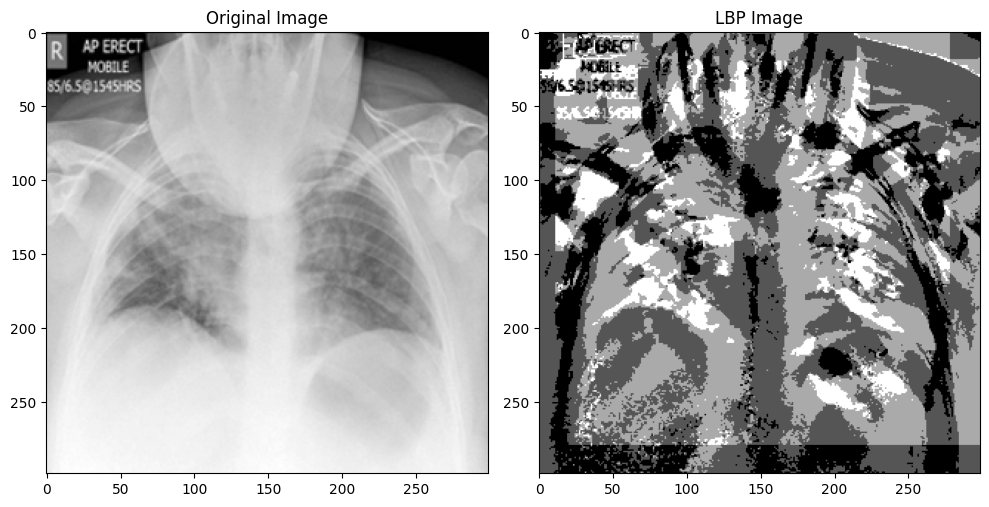

In [5]:
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage.io import imread
import numpy as np

image = imread("/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/COVID-358.png")  # Your input image
radius = 3      # Radio
n_points = 21   # Numero de puntos

# Calcular LBP
lbp_image = local_binary_pattern(image, radius, n_points, method='uniform')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(lbp_image, cmap='gray')
axes[1].set_title('LBP Image')
plt.tight_layout()
plt.show()


In [7]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
import torch

input_folders = ["/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/",
                 "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity/",
                 "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/",
                 "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral_Pneumonia/"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lbp_np_arrays = []
labels_np = []
for i, folder in enumerate(input_folders):
    input_folder = folder
    print(input_folder)
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)
            # Mover imagen a la GPU
            image_tensor = torch.from_numpy(image).to(device)   
            # Quitar bordes en la GPU
            cropped_image_tensor = image_tensor[20:280, 20:280, :]
            cropped_image_tensor = cropped_image_tensor.float()
            gray_image_tensor = torch.mean(cropped_image_tensor, dim=2, keepdim=True)
            gray_image_np = gray_image_tensor.squeeze().cpu().numpy()
            # Aplicar LBP
            lbp_image = local_binary_pattern(gray_image_np, 3, 21, method='uniform')
            lbp_image = lbp_image.astype(np.uint8)
            lbp_array = lbp_image.flatten()
            lbp_np_arrays.append(lbp_array)
            labels_np.append(i)

np.save("drive/MyDrive/lbp_arrays.npy", lbp_np_arrays)
np.save("drive/MyDrive/lbp_labels.npy", labels_np)

/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/
/content/drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity/
/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/
/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral_Pneumonia/


In [1]:
#=====  Feature Engineering  =====#
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
lbp_arrays_loaded = np.load("/content/drive/MyDrive/lbp_arrays.npy")
labels_np = np.load("/content/drive/MyDrive/lbp_labels.npy")

# Dividir los datos en train y test y estratificar
train_lbp, test_lbp, train_labels, test_labels = train_test_split(
    lbp_arrays_loaded, labels_np, test_size=0.2, stratify=labels_np, random_state=42)

lbp_arrays_loaded = []
labels_np = []
del lbp_arrays_loaded, labels_np

# Normalización de los datos
scaler = MinMaxScaler()
scaler.fit(train_lbp)
scaled_data = scaler.transform(train_lbp)
train_lbp = scaled_data
scaler = MinMaxScaler()
scaler.fit(test_lbp)
scaled_data = scaler.transform(test_lbp)
test_lbp = scaled_data
scaled_data = []
del scaled_data

# Convertir de numpy array a PyTorch tensor
lbp_train_tensor = torch.from_numpy(train_lbp).float()
del train_lbp
lbp_test_tensor = torch.from_numpy(test_lbp).float()
del test_lbp
labels_train_tensor = torch.from_numpy(train_labels).float()
del train_labels
labels_test_tensor = torch.from_numpy(test_labels).float()
del test_labels

# Convertir a tensores de tipo long
labels_train_long_tensor = labels_train_tensor.long()         
# Convertir a one hot
labels_onehot = F.one_hot(labels_train_long_tensor, num_classes=4).float()

# Convertir datos a PyTorch Dataset
train_dataset = data.TensorDataset(lbp_train_tensor, labels_train_tensor)
# Definir batch size
batch_size = 32
# Crear DataLoaders
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_ = data.DataLoader(train_dataset, batch_size=batch_size)

# Convertir datos a PyTorch Dataset
val_dataset = data.TensorDataset(lbp_test_tensor, labels_test_tensor)
# Crear DataLoaders
val_loader = data.DataLoader(val_dataset, batch_size=batch_size)



In [12]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, activation):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_layers = nn.ModuleList()
        self.num_classes = num_classes
        self.activation = activation
        # Agregar capas ocultas
        for i, hidden_size in enumerate(hidden_sizes):
            if i == 0:
                self.hidden_layers.append(nn.Linear(input_size, hidden_size))
            else:
                self.hidden_layers.append(nn.Linear(hidden_sizes[i-1], hidden_size))
        # Capa de salida
        self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)
        
    def forward(self, x):
        out = x
        # Pasar por capas ocultas
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.activation(out)
        # Pasar por capa de salida
        out = self.output_layer(out)
        return out

### Diseño # 1
Capas: [67600, 128, 64, 4] | Función de activación: ReLU | epochs = 120

|==========  Entrenando el modelo  ==========|

Epoch: [20/120], Loss: 0.2445
Epoch: [40/120], Loss: 0.0117
Epoch: [60/120], Loss: 0.0836
Epoch: [80/120], Loss: 0.1666
Epoch: [100/120], Loss: 0.4859
Epoch: [120/120], Loss: 0.3281

|==========  Resultados conjunto de prueba  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.54192,0.579431,0.567933,0.572765,0.704358,245.248518


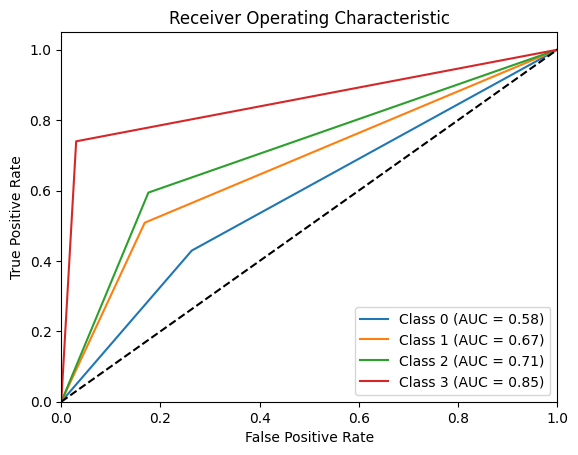

Resultados esperados:  tensor([3., 1., 0., 2., 2., 2., 3., 1.])
Resultados obtenidos:  [0, 0, 0, 0, 2, 2, 3, 2]
Probabilidades obtenidas:  [[0.5012038946151733, 0.4970835745334625, 0.00011111254571005702, 0.0016014082357287407], [0.8813148140907288, 0.11499922722578049, 0.0035122334957122803, 0.00017378453048877418], [0.8341980576515198, 0.1636541485786438, 0.00185979378875345, 0.00028796453261747956], [0.6360539793968201, 0.3626854717731476, 0.0003102011396549642, 0.0009503581095486879], [2.5507580333396616e-21, 1.1345677869423199e-10, 0.9999998807907104, 1.2082267630830756e-07], [0.012080819346010685, 0.0019319633720442653, 0.98598712682724, 2.5176472462362653e-08], [1.2564612461574143e-06, 4.6901408978783365e-08, 0.0002778991765808314, 0.9997208714485168], [3.7292129491106607e-06, 8.18812768557109e-05, 0.9999103546142578, 4.095942585990997e-06]]

|==========  Resultados conjunto de entrenamiento  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.854047,0.873708,0.868986,0.869437,0.908757,245.248518


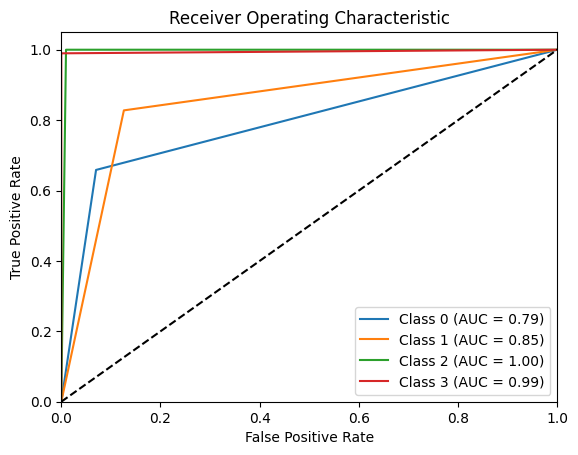

Resultados esperados:  tensor([1., 1., 1., 2., 2., 2., 2., 2.])
Resultados obtenidos:  [1, 1, 1, 2, 2, 2, 2, 2]


In [14]:
# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = lbp_train_tensor.shape[1]
hidden_sizes = [128, 64]       
num_classes = 4
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation) .to(device)  

# Definir funcion de costo
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Entrenar el modelo
num_epochs = 120
print('|==========  Entrenando el modelo  ==========|\n')
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        outputs = outputs.float()
        labels = labels.long()
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        average_loss = running_loss / len(train_loader)
        # Imprimir el training loss
    if (epoch+1) % 20 == 0:
        print(f"Epoch: [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

end_time = time.time()
time_taken = end_time - start_time

print('\n|==========  Resultados conjunto de prueba  ==========|\n')
# Evaluar el modelo
model.eval() 
predicted_labels = []
predicted_probs = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.tolist())
        probs = F.softmax(outputs, dim=1)
        predicted_probs.extend(probs.tolist())
    # Obtener métricas
    computeMetrics(labels_test_tensor, predicted_labels, time_taken)
    print('Resultados esperados: ', labels_test_tensor[:8])
    print('Resultados obtenidos: ', predicted_labels[:8])
    print('Probabilidades obtenidas: ', predicted_probs[:8])

print('\n|==========  Resultados conjunto de entrenamiento  ==========|\n')
# Evaluar el modelo con el conjunto de training
model.eval()
predicted_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in train_loader_:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.tolist())
    # Obtener métricas
    computeMetrics(labels_train_tensor, predicted_labels, time_taken)
    print('Resultados esperados: ', labels_train_tensor[:8])
    print('Resultados obtenidos: ', predicted_labels[:8])

### Diseño # 2
Capas: [67600, 64, 4] | Función de activación: ReLU | epochs = 120

|==========  Entrenando el modelo  ==========|

Epoch: [20/120], Loss: 1.0398
Epoch: [40/120], Loss: 0.9655
Epoch: [60/120], Loss: 0.9353
Epoch: [80/120], Loss: 0.8944
Epoch: [100/120], Loss: 0.9392
Epoch: [120/120], Loss: 0.8985

|==========  Resultados conjunto de prueba  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.691335,0.708871,0.70931,0.704804,0.80094,203.803543


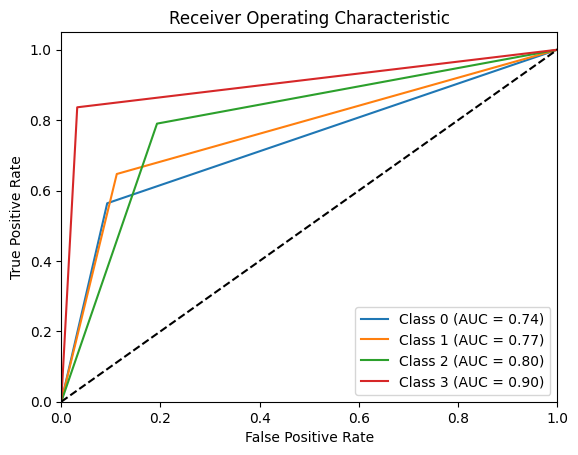

Resultados esperados:  tensor([3., 1., 0., 2., 2., 2., 3., 1.])
Resultados obtenidos:  [0, 0, 2, 0, 2, 2, 3, 0]

|==========  Resultados conjunto de entrenamiento  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.864941,0.87683,0.878659,0.876753,0.915683,203.803543


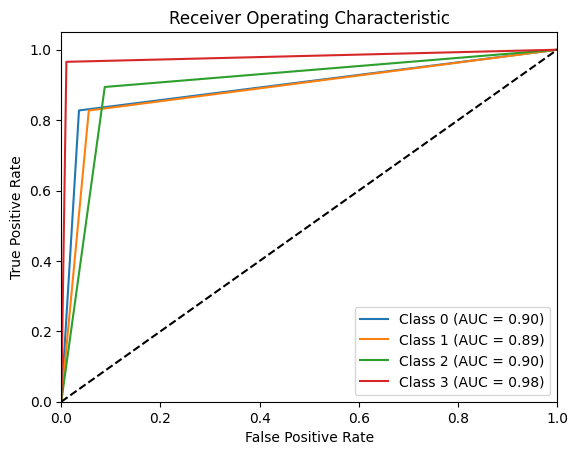

Resultados esperados:  tensor([1., 1., 1., 2., 2., 2., 2., 2.])
Resultados obtenidos:  [1, 1, 0, 2, 1, 2, 2, 2]


In [13]:
# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = lbp_train_tensor.shape[1]
hidden_sizes = [64]       
num_classes = 4
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation) .to(device)  

# Definir funcion de costo
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Entrenar el modelo
num_epochs = 120
print('|==========  Entrenando el modelo  ==========|\n')
start_time = time.time()
for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        outputs = outputs.float()
        labels = labels.long()
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        average_loss = running_loss / len(train_loader)
        # Imprimir el training loss
    if (epoch+1) % 20 == 0:
        print(f"Epoch: [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

end_time = time.time()
time_taken = end_time - start_time

print('\n|==========  Resultados conjunto de prueba  ==========|\n')
# Evaluar el modelo
model.eval() 
predicted_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.tolist())
    # Obtener métricas
    computeMetrics(labels_test_tensor, predicted_labels, time_taken)
    print('Resultados esperados: ', labels_test_tensor[:8])
    print('Resultados obtenidos: ', predicted_labels[:8])

print('\n|==========  Resultados conjunto de entrenamiento  ==========|\n')
# Evaluar el modelo con el conjunto de training
model.eval()
predicted_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in train_loader_:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.tolist())
    # Obtener métricas
    computeMetrics(labels_train_tensor, predicted_labels, time_taken)
    print('Resultados esperados: ', labels_train_tensor[:8])
    print('Resultados obtenidos: ', predicted_labels[:8])

### Diseño # 3
Capas: [67600, 64, 32, 16, 4] | Función de activación: ReLU | epochs = 120

|==========  Entrenando el modelo  ==========|

Epoch: [20/120], Loss: 0.3785
Epoch: [40/120], Loss: 0.1263
Epoch: [60/120], Loss: 0.0573
Epoch: [80/120], Loss: 0.0249
Epoch: [100/120], Loss: 0.0596
Epoch: [120/120], Loss: 0.1024

|==========  Resultados conjunto de prueba  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.700703,0.719044,0.720219,0.718583,0.807991,199.418761


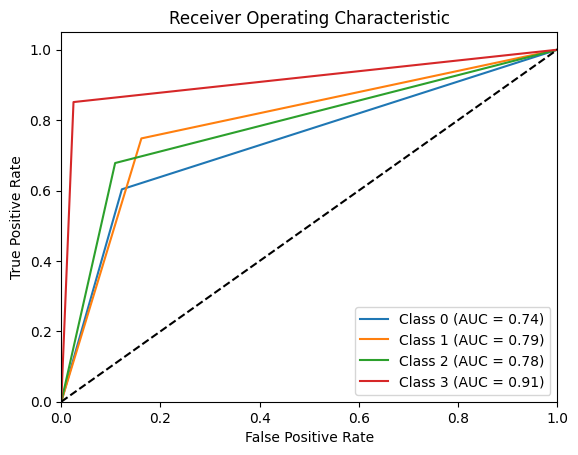

Resultados esperados:  tensor([3., 1., 0., 2., 2., 2., 3., 1.])
Resultados obtenidos:  [3, 1, 0, 2, 2, 2, 3, 1]

|==========  Resultados conjunto de entrenamiento  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.994026,0.994567,0.994599,0.994568,0.996251,199.418761


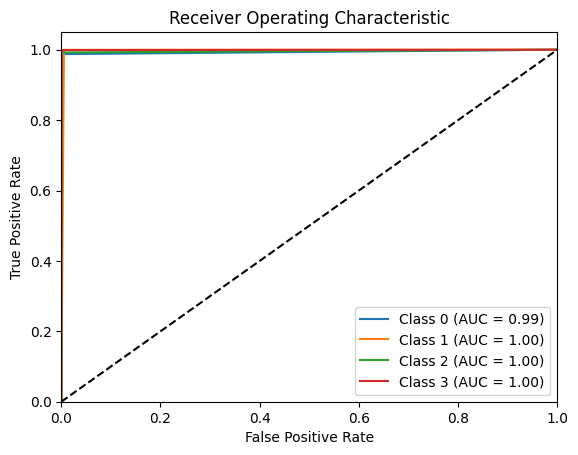

Resultados esperados:  tensor([1., 1., 1., 2., 2., 2., 2., 2.])
Resultados obtenidos:  [1, 1, 1, 2, 2, 2, 2, 2]


In [ ]:
# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = lbp_train_tensor.shape[1]
hidden_sizes = [64, 32, 16]       
num_classes = 4
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation) .to(device)  

# Definir funcion de costo
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Entrenar el modelo
num_epochs = 120
print('|==========  Entrenando el modelo  ==========|\n')
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        outputs = outputs.float()
        labels = labels.long()
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        average_loss = running_loss / len(train_loader)
        # Imprimir el training loss
    if (epoch+1) % 20 == 0:
        print(f"Epoch: [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

end_time = time.time()
time_taken = end_time - start_time

print('\n|==========  Resultados conjunto de prueba  ==========|\n')
# Evaluar el modelo
model.eval() 
predicted_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.tolist())
    # Obtener métricas
    computeMetrics(labels_test_tensor, predicted_labels, time_taken)
    print('Resultados esperados: ', labels_test_tensor[:8])
    print('Resultados obtenidos: ', predicted_labels[:8])

print('\n|==========  Resultados conjunto de entrenamiento  ==========|\n')
# Evaluar el modelo con el conjunto de training
model.eval()
predicted_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in train_loader_:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.tolist())
    # Obtener métricas
    computeMetrics(labels_train_tensor, predicted_labels, time_taken)
    print('Resultados esperados: ', labels_train_tensor[:8])
    print('Resultados obtenidos: ', predicted_labels[:8])

# CNN

In [ ]:
import os
import cv2
import time
import math
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import display
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from google.colab import drive
from keras.utils import to_categorical
from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [ ]:
def computeMetrics(y_test, y_pred, training_time):
    acc = accuracy_score(y_test, y_pred)                        # Calcular la exactitud
    f1 = f1_score(y_test, y_pred, average='macro')              # Calcular F1 score
    rec = recall_score(y_test, y_pred, average='macro')         # Calcular el recall
    prec = precision_score(y_test, y_pred, average='macro')     # Calcular la precisión
    metrics = {"Accuracy":acc, "Precision":prec, "Recall":rec, "F1 Score":f1, "Tiempo de entrenamiento":training_time}
    df = pd.DataFrame(metrics, index = [0])
    display(df)


### Importar imágenes del set de datos

In [ ]:
# Ruta a la carpeta del conjunto de datos en Google Drive
data_folders =  ["/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID", "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity",
                 "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal", "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral Pneumonia"]

#data_folders =  ["/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID"]

# Cargar y procesar el conjunto de datos
images = []
labels = []

class_labels = ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

for i, data_folder in enumerate(data_folders):
    image_files = os.listdir(data_folder)
    print(data_folder)
    for filename in image_files:
        image_path = os.path.join(data_folder, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (299, 299))
        # Especificar el tamaño del recorte de bordes
        recorte_bordes = 20

        # Calcular las nuevas dimensiones
        nuevo_alto = 299 - 2 * recorte_bordes
        nuevo_ancho = 299 - 2 * recorte_bordes

        # Recortar la imagen eliminando los bordes
        image = image[recorte_bordes:299-recorte_bordes, recorte_bordes:299-recorte_bordes]

        images.append(image)
        label = i  # Asignar la etiqueta de clase según el índice
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

print(images.shape)
cv2_imshow(images[2])



In [ ]:
# Dividir el conjunto de datos en entrenamiento y prueba
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
try:
    train_images = np.load("/content/drive/MyDrive/train_images.npy")
    print("Paso train_images")
    test_images = np.load("/content/drive/MyDrive/test_images.npy")
    print("Paso test_images")
    train_labels = np.load("/content/drive/MyDrive/train_labels.npy")
    print("Paso train_labels")
    test_labels = np.load("/content/drive/MyDrive/test_labels.npy")
    print("Paso test_labels")
except FileNotFoundError:
    print("Error: File not found.")

Paso train_images
Paso test_images
Paso train_labels
Paso test_labels


## Aplicar el filtro bilateral

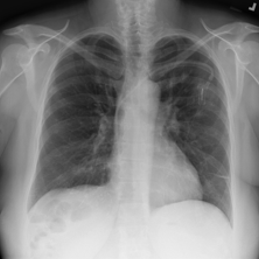

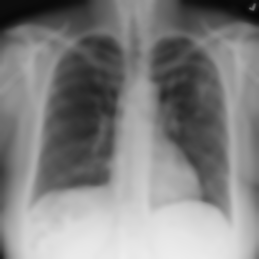

In [ ]:
# Aplicar el filtro bilateral a las imágenes offline y guardarlas
filtered_train_images = np.empty_like(train_images)
filtered_test_images = np.empty_like(test_images)

for i in range(len(train_images)):
    filtered_image = cv2.bilateralFilter(train_images[i], 9, 75, 75)
    filtered_train_images[i] = filtered_image

for i in range(len(test_images)):
    filtered_image = cv2.bilateralFilter(test_images[i], 9, 75, 75)
    filtered_test_images[i] = filtered_image

cv2_imshow(train_images[2])
cv2_imshow(filtered_train_images[2])

## Arquitectura propia sin filtro

In [ ]:
# Definir la arquitectura de la CNN
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(259, 259, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Compilar y entrenar la CNN con imágenes en bruto
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))
end_time = time.time()
time_taken = end_time - start_time
# Evaluar la CNN con imágenes en bruto
#-----------------------------------------------------------------------------
# Obtener las predicciones del modelo en las imágenes de prueba
predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)

computeMetrics(test_labels,predictions,time_taken)

#-----------------------------------------------------------------------------


Epoch 1/10
530/530 [==============================] - 1390s 3s/step - loss: 168.9818 - accuracy: 0.5917 - val_loss: 2.0928 - val_accuracy: 0.6707
Epoch 2/10
530/530 [==============================] - 1220s 2s/step - loss: 1.2195 - accuracy: 0.7296 - val_loss: 2.2182 - val_accuracy: 0.6201
Epoch 3/10
530/530 [==============================] - 1221s 2s/step - loss: 0.8722 - accuracy: 0.7839 - val_loss: 2.3265 - val_accuracy: 0.6612
Epoch 4/10
530/530 [==============================] - 1215s 2s/step - loss: 0.6422 - accuracy: 0.8313 - val_loss: 2.3572 - val_accuracy: 0.6714
Epoch 5/10
530/530 [==============================] - 1208s 2s/step - loss: 0.5320 - accuracy: 0.8635 - val_loss: 2.4928 - val_accuracy: 0.6688
Epoch 6/10
530/530 [==============================] - 1206s 2s/step - loss: 0.5116 - accuracy: 0.8767 - val_loss: 2.6262 - val_accuracy: 0.6768
Epoch 7/10
530/530 [==============================] - 1194s 2s/step - loss: 0.4390 - accuracy: 0.8970 - val_loss: 2.9166 - val_accurac

133/133 [==============================] - 79s 595ms/step


,Accuracy,Precision,Recall,F1 Score,Tiempo de entrenamiento
0,0.673754,0.656758,0.661848,0.658742,12268.233386


## Arquitectura funcional

In [ ]:
# Cargar los datos de imágenes y etiquetas
try:
    train_images = np.load("/content/drive/MyDrive/train_images.npy")
    print("Paso train_images")
    test_images = np.load("/content/drive/MyDrive/test_images.npy")
    print("Paso test_images")
    train_labels = np.load("/content/drive/MyDrive/train_labels.npy")
    print("Paso train_labels")
    test_labels = np.load("/content/drive/MyDrive/test_labels.npy")
    print("Paso test_labels")
except FileNotFoundError:
    print("Error: File not found.")

mitad = len(train_images) // 3
train_images = train_images[:mitad]

mitad = len(test_images) // 3
test_images = test_images[:mitad]

mitad = len(train_labels) // 3
train_labels = train_labels[:mitad]

mitad = len(test_labels) // 3
test_labels = test_labels[:mitad]
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)


# Normalizar las imágenes y convertir las etiquetas a codificación one-hot
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


Paso train_images
Paso test_images
Paso train_labels
Paso test_labels
(5644, 259, 259)
(1411, 259, 259)
(5644,)
(1411,)


#### Test Results

Epoch 1/5
706/706 [==============================] - 28s 21ms/step - loss: 0.8999 - accuracy: 0.6304 - val_loss: 0.9451 - val_accuracy: 0.6272
Epoch 2/5
706/706 [==============================] - 14s 19ms/step - loss: 0.7196 - accuracy: 0.7073 - val_loss: 0.7041 - val_accuracy: 0.6995
Epoch 3/5
706/706 [==============================] - 15s 22ms/step - loss: 0.6219 - accuracy: 0.7481 - val_loss: 0.5689 - val_accuracy: 0.7782
Epoch 4/5
706/706 [==============================] - 15s 22ms/step - loss: 0.5412 - accuracy: 0.7837 - val_loss: 0.5625 - val_accuracy: 0.7654
Epoch 5/5
45/45 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.65      0.64      0.64       251
           1       0.84      0.69      0.76       412
           2       0.81      0.90      0.85       647
           3       0.85      0.88      0.86       101

    accuracy                           0.79      1411
   macro avg       0.79      0.78     

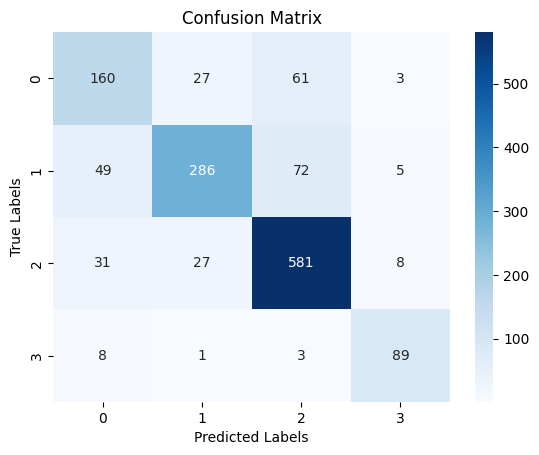

In [ ]:

# Definir el modelo CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(259, 259, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Reemplaza 10 con el número de clases

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(train_images, train_labels, epochs=5, batch_size=8, validation_data=(test_images, test_labels))

# Evaluar el modelo en los datos de prueba
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)
print(classification_report(true_labels, predicted_labels))
# Calcular la matriz de confusión
confusion = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')

# Configurar etiquetas de los ejes
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Mostrar el mapa de calor
plt.show()

### Train Results

177/177 [==============================] - 3s 17ms/step
              precision    recall  f1-score   support

           0       0.79      0.72      0.75       976
           1       0.91      0.76      0.83      1610
           2       0.85      0.95      0.90      2717
           3       0.91      0.95      0.93       341

    accuracy                           0.86      5644
   macro avg       0.86      0.85      0.85      5644
weighted avg       0.86      0.86      0.85      5644



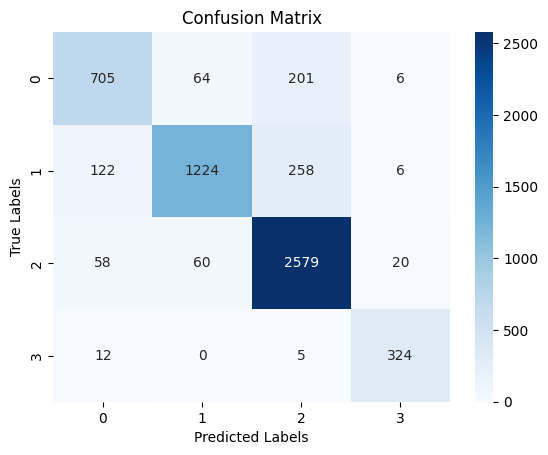

In [ ]:
# Evaluar el modelo en los datos de prueba
predictions = model.predict(train_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(train_labels, axis=1)
print(classification_report(true_labels, predicted_labels))
# Calcular la matriz de confusión
confusion = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')

# Configurar etiquetas de los ejes
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Mostrar el mapa de calor
plt.show()

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 257, 257, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 238144)            0

## Arquitectura propia Con Filtro

In [ ]:
# Definir una nueva arquitectura de la CNN
model_filtered = keras.models.Sequential()
model_filtered.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(259, 259, 1)))
model_filtered.add(layers.MaxPooling2D((2, 2)))
model_filtered.add(layers.Flatten())
model_filtered.add(layers.Dense(64, activation='relu'))
model_filtered.add(layers.Dense(10, activation='softmax'))

# Compilar y entrenar la CNN con imágenes filtradas
model_filtered.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
model_filtered.fit(filtered_train_images, train_labels, epochs=10, batch_size=8, validation_data=(filtered_test_images, test_labels))
end_time = time.time()
time_taken = end_time - start_time
# Evaluar la CNN con imágenes filtradas
#-----------------------------------------------------------------------------
# Obtener las predicciones del modelo en las imágenes de prueba
predictions = model_filtered.predict(test_images)
predictions = np.argmax(predictions, axis=1)

computeMetrics(test_labels,predictions,time_taken)
#-----------------------------------------------------------------------------


Epoch 1/10
2117/2117 [==============================] - 34s 15ms/step - loss: 24.7176 - accuracy: 0.5356 - val_loss: 1.1343 - val_accuracy: 0.5875
Epoch 2/10
2117/2117 [==============================] - 32s 15ms/step - loss: 0.9645 - accuracy: 0.6255 - val_loss: 1.0781 - val_accuracy: 0.6145
Epoch 3/10
2117/2117 [==============================] - 32s 15ms/step - loss: 0.8242 - accuracy: 0.6856 - val_loss: 1.2642 - val_accuracy: 0.5374
Epoch 4/10
2117/2117 [==============================] - 31s 15ms/step - loss: 0.7469 - accuracy: 0.7058 - val_loss: 1.2156 - val_accuracy: 0.6017
Epoch 5/10
2117/2117 [==============================] - 32s 15ms/step - loss: 0.7321 - accuracy: 0.7147 - val_loss: 1.3879 - val_accuracy: 0.5771
Epoch 6/10
2117/2117 [==============================] - 33s 15ms/step - loss: 0.8388 - accuracy: 0.6782 - val_loss: 1.4130 - val_accuracy: 0.5509
Epoch 7/10
2117/2117 [==============================] - 32s 15ms/step - loss: 0.7670 - accuracy: 0.6854 - val_loss: 1.5401 

,Accuracy,Precision,Recall,F1 Score,Tiempo de entrenamiento
0,0.580439,0.534144,0.426432,0.446533,324.508433


## Arquitectura funcional

Paso train_images
Paso test_images
Paso train_labels
Paso test_labels
(5644, 259, 259)
(1411, 259, 259)
(5644,)
(1411,)


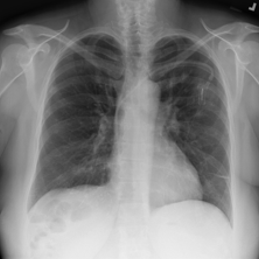

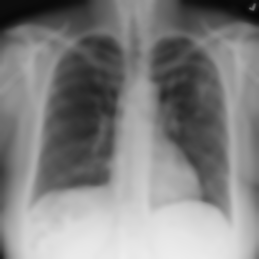

In [ ]:
# Cargar los datos de imágenes y etiquetas
try:
    train_images = np.load("/content/drive/MyDrive/train_images.npy")
    print("Paso train_images")
    test_images = np.load("/content/drive/MyDrive/test_images.npy")
    print("Paso test_images")
    train_labels = np.load("/content/drive/MyDrive/train_labels.npy")
    print("Paso train_labels")
    test_labels = np.load("/content/drive/MyDrive/test_labels.npy")
    print("Paso test_labels")
except FileNotFoundError:
    print("Error: File not found.")

mitad = len(train_images) // 3
train_images = train_images[:mitad]

mitad = len(test_images) // 3
test_images = test_images[:mitad]

mitad = len(train_labels) // 3
train_labels = train_labels[:mitad]

mitad = len(test_labels) // 3
test_labels = test_labels[:mitad]
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)


# Aplicar el filtro bilateral a las imágenes offline y guardarlas
filtered_train_images = np.empty_like(train_images)
filtered_test_images = np.empty_like(test_images)


for i in range(len(train_images)):
    filtered_image = cv2.bilateralFilter(train_images[i], 9, 75, 75)
    filtered_train_images[i] = filtered_image

for i in range(len(test_images)):
    filtered_image = cv2.bilateralFilter(test_images[i], 9, 75, 75)
    filtered_test_images[i] = filtered_image

cv2_imshow(train_images[2])
cv2_imshow(filtered_train_images[2])

# Normalizar las imágenes y convertir las etiquetas a codificación one-hot
filtered_train_images = filtered_train_images.astype('float32') / 255.0
filtered_test_images = filtered_test_images.astype('float32') / 255.0
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

### Test Results

In [ ]:

# Definir el modelo CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(259, 259, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Reemplaza 10 con el número de clases

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(filtered_train_images, train_labels, epochs=5, batch_size=8, validation_data=(filtered_test_images, test_labels))



Epoch 1/5
706/706 [==============================] - 17s 21ms/step - loss: 0.9704 - accuracy: 0.6084 - val_loss: 0.8578 - val_accuracy: 0.6549
Epoch 2/5
706/706 [==============================] - 13s 19ms/step - loss: 0.7911 - accuracy: 0.6727 - val_loss: 0.6831 - val_accuracy: 0.7108
Epoch 3/5
706/706 [==============================] - 13s 19ms/step - loss: 0.6867 - accuracy: 0.7193 - val_loss: 0.6505 - val_accuracy: 0.7286
Epoch 4/5
706/706 [==============================] - 13s 18ms/step - loss: 0.5988 - accuracy: 0.7589 - val_loss: 0.6227 - val_accuracy: 0.7413
Epoch 5/5
706/706 [==============================] - 13s 18ms/step - loss: 0.5320 - accuracy: 0.7959 - val_loss: 0.6259 - val_accuracy: 0.7434


45/45 [==============================] - 1s 19ms/step
              precision    recall  f1-score   support

           0       0.60      0.47      0.53       251
           1       0.68      0.78      0.73       412
           2       0.83      0.81      0.82       647
           3       0.76      0.84      0.80       101

    accuracy                           0.74      1411
   macro avg       0.72      0.72      0.72      1411
weighted avg       0.74      0.74      0.74      1411



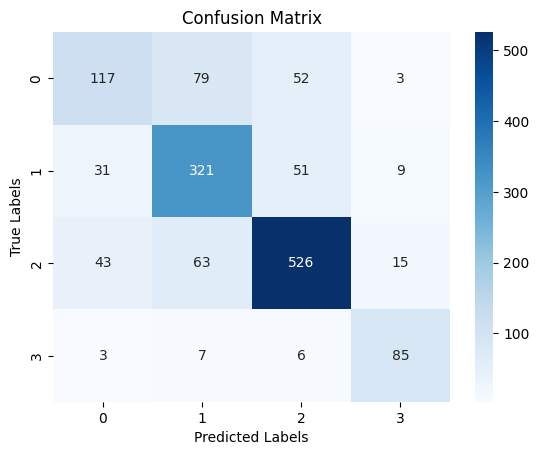

In [ ]:
# Evaluar el modelo en los datos de prueba
predictions = model.predict(filtered_test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)
print(classification_report(true_labels, predicted_labels))

# Calcular la matriz de confusión
confusion = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')

# Configurar etiquetas de los ejes
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Mostrar el mapa de calor
plt.show()

### Train Results

177/177 [==============================] - 3s 16ms/step
              precision    recall  f1-score   support

           0       0.76      0.56      0.64       976
           1       0.76      0.86      0.80      1610
           2       0.87      0.88      0.88      2717
           3       0.87      0.94      0.90       341

    accuracy                           0.82      5644
   macro avg       0.81      0.81      0.81      5644
weighted avg       0.82      0.82      0.82      5644



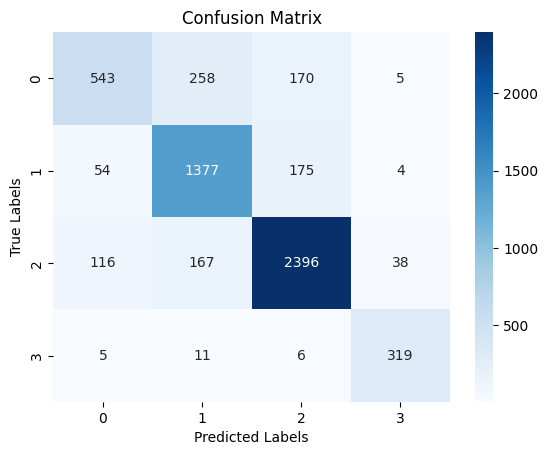

In [ ]:
# Evaluar el modelo en los datos de prueba
predictions = model.predict(filtered_train_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(train_labels, axis=1)
print(classification_report(true_labels, predicted_labels))

# Calcular la matriz de confusión
confusion = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')

# Configurar etiquetas de los ejes
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Mostrar el mapa de calor
plt.show()

# Visualización de Mapas de Calor

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

## Covid-19

In [ ]:
#Cargar el modelo InceptionV3 pre-entrenado
model = InceptionV3(weights='imagenet')

# Cargar una imagen de ejemplo
img_path = './COVID-19_Radiography_Dataset/COVID/COVID-1.png'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = preprocess_input(x)
x = np.expand_dims(x, axis=0)

In [ ]:
# Obtener la capa de interés
layer_name = 'mixed10'
last_conv_layer = model.get_layer(layer_name)

# Crear un nuevo modelo que incluya solo las capas hasta la capa de interés
new_model = tf.keras.models.Model(inputs=model.input, outputs=last_conv_layer.output)

# Obtener los mapas de activación de la capa de interés
activations = new_model.predict(x)


1/1 [==============================] - 3s 3s/step


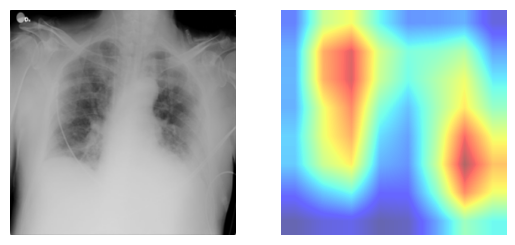

In [ ]:
# Calcular los valores de importancia de los mapas de activación
importance_values = np.mean(activations, axis=(0, 1))


# Ajustar el tamaño del peso para que coincida con el tamaño del mapa de activación
weights = np.expand_dims(np.expand_dims(importance_values, axis=0), axis=0)

# Generar el mapa de calor ponderado
heatmap = tf.reduce_sum(tf.multiply(weights, activations), axis=-1)[0]

# Normalizar el mapa de calor
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Ajustar el tamaño del mapa de calor para que coincida con el tamaño de la imagen
heatmap = np.expand_dims(heatmap, axis=-1)
heatmap = tf.image.resize(heatmap, (img.size[1], img.size[0]))
heatmap = tf.squeeze(heatmap)
heatmap = heatmap.numpy()

# Visualizar la imagen original
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

# Visualizar el mapa de calor
plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet', alpha=0.6)
plt.axis('off')

plt.show()

## Normal

1/1 [==============================] - 0s 147ms/step


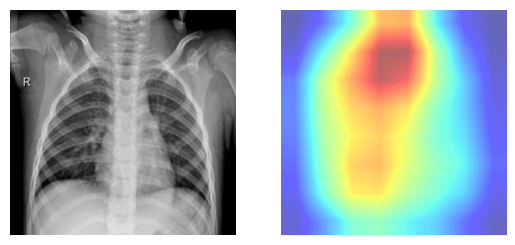

In [ ]:
# Cargar una imagen de ejemplo
img_path = './COVID-19_Radiography_Dataset/Normal/Normal-313.png'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = preprocess_input(x)
x = np.expand_dims(x, axis=0)

# Obtener los mapas de activación de la capa de interés
activations = new_model.predict(x)
# Calcular los valores de importancia de los mapas de activación
importance_values = np.mean(activations, axis=(0, 1))


# Ajustar el tamaño del peso para que coincida con el tamaño del mapa de activación
weights = np.expand_dims(np.expand_dims(importance_values, axis=0), axis=0)

# Generar el mapa de calor ponderado
heatmap = tf.reduce_sum(tf.multiply(weights, activations), axis=-1)[0]

# Normalizar el mapa de calor
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Ajustar el tamaño del mapa de calor para que coincida con el tamaño de la imagen
heatmap = np.expand_dims(heatmap, axis=-1)
heatmap = tf.image.resize(heatmap, (img.size[1], img.size[0]))
heatmap = tf.squeeze(heatmap)
heatmap = heatmap.numpy()

# Visualizar la imagen original
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

# Visualizar el mapa de calor
plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet', alpha=0.6)
plt.axis('off')

plt.show()

## Opacidad pulmonar

1/1 [==============================] - 0s 145ms/step


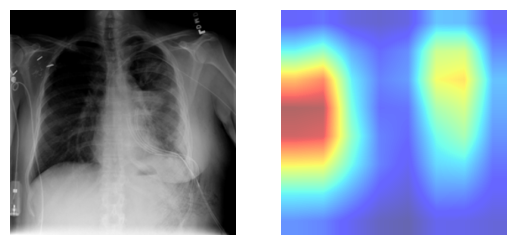

In [ ]:
# Cargar una imagen de ejemplo
img_path = './COVID-19_Radiography_Dataset/Lung_Opacity/Lung_Opacity-1.png'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = preprocess_input(x)
x = np.expand_dims(x, axis=0)

# Obtener los mapas de activación de la capa de interés
activations = new_model.predict(x)
# Calcular los valores de importancia de los mapas de activación
importance_values = np.mean(activations, axis=(0, 1))


# Ajustar el tamaño del peso para que coincida con el tamaño del mapa de activación
weights = np.expand_dims(np.expand_dims(importance_values, axis=0), axis=0)

# Generar el mapa de calor ponderado
heatmap = tf.reduce_sum(tf.multiply(weights, activations), axis=-1)[0]

# Normalizar el mapa de calor
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Ajustar el tamaño del mapa de calor para que coincida con el tamaño de la imagen
heatmap = np.expand_dims(heatmap, axis=-1)
heatmap = tf.image.resize(heatmap, (img.size[1], img.size[0]))
heatmap = tf.squeeze(heatmap)
heatmap = heatmap.numpy()

# Visualizar la imagen original
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

# Visualizar el mapa de calor
plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet', alpha=0.6)
plt.axis('off')

plt.show()

## Neumonía viral

1/1 [==============================] - 0s 169ms/step


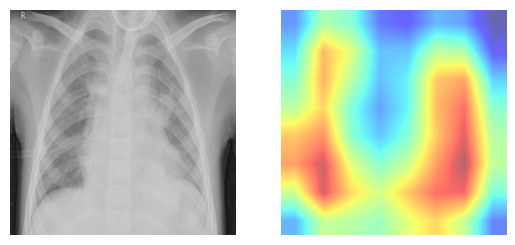

In [ ]:
# Cargar una imagen de ejemplo
img_path = './COVID-19_Radiography_Dataset/Viral_Pneumonia/Viral Pneumonia-1007.png'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = preprocess_input(x)
x = np.expand_dims(x, axis=0)

# Obtener los mapas de activación de la capa de interés
activations = new_model.predict(x)
# Calcular los valores de importancia de los mapas de activación
importance_values = np.mean(activations, axis=(0, 1))


# Ajustar el tamaño del peso para que coincida con el tamaño del mapa de activación
weights = np.expand_dims(np.expand_dims(importance_values, axis=0), axis=0)

# Generar el mapa de calor ponderado
heatmap = tf.reduce_sum(tf.multiply(weights, activations), axis=-1)[0]

# Normalizar el mapa de calor
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Ajustar el tamaño del mapa de calor para que coincida con el tamaño de la imagen
heatmap = np.expand_dims(heatmap, axis=-1)
heatmap = tf.image.resize(heatmap, (img.size[1], img.size[0]))
heatmap = tf.squeeze(heatmap)
heatmap = heatmap.numpy()

# Visualizar la imagen original
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

# Visualizar el mapa de calor
plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet', alpha=0.6)
plt.axis('off')

plt.show()